In [ ]:
import init
import utils

import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display_markdown, display_html

In [2]:
DATA_REPORTS_PATH = '../data/RTVSlo/Podatki - rtvslo.si/**/*.rtf'
DATA_PROMET_SI_PATH = '../data/RTVSlo/Podatki - PrometnoPorocilo_2022_2023_2024.xlsx'

In [3]:
df_reports = utils.data.load_traffic_reports(DATA_REPORTS_PATH)
df_promet = utils.data.load_promet_si(DATA_PROMET_SI_PATH)

Loading cached DataFrame from c:\Users\janez\FRI\data-science\semester-2\NLP\Project\utils\../data/parsed/traffic_reports.csv


## Displaying a traffic report and relevant `Promet.si` entries

In [4]:
def display_traffic_report(report: pd.Series, n_promet_si_entries = 3):
    # Determine the promet.si entries related to report
    timestamp_ref = report['datetime']
    timestamp_diff = (df_promet['Datum'] - timestamp_ref).abs()
    timestamp_diff = timestamp_diff[df_promet['Datum'] <= timestamp_ref] # Only consider promet.si dates before the reference
    idx_closest = timestamp_diff.sort_values().index[:n_promet_si_entries]

    # Display the report
    dt_format = "%d. %m. %Y, %H:%M"
    display_markdown(f'# {report["type"]} (**{report["datetime"].strftime(dt_format)}**)', raw=True)
    print(report['content'])
    display_markdown(f'The {n_promet_si_entries} most relevant promet.si entries are displayed below.', raw=True)

    # Display the promet.si entries
    for i, (_, row) in enumerate(df_promet.loc[idx_closest].iterrows()):
        display_html('<hr>', raw=True)
        display_markdown(f'### [{i+1}] **{row.Datum.strftime("%d. %m. %Y, %H:%M")}**', raw=True)
        if pd.notna(row.A1): display_html(row.A1, raw=True)
        if pd.notna(row.B1): display_html(row.B1, raw=True)

In [5]:
df_reports[df_reports.text.str.contains('vozi v nasprotn')]

,type,date,time,programme,content,text,path,datetime
4317,Prometne informacije,2022-06-17,20:10:00,2. program,Izredna prometna informacija.\nVozniki na prim...,Prometne informacije \t 17. 06. 2022\t 2...,../data/RTVSlo/Podatki - rtvslo.si\Promet 2022...,2022-06-17 20:10:00
18726,Nujne prometne informacije,2023-12-10,23:45:00,1. in 2. program,Nujna prometna informacija\nNa štajerski avtoc...,NUJNO! Prometne informacije 10. 12. 202...,../data/RTVSlo/Podatki - rtvslo.si\Promet 2023...,2023-12-10 23:45:00


In [6]:
row_report = df_reports.iloc[7209]
display_traffic_report(row_report)

# Prometne informacije (**05. 10. 2022, 10:30**)

Podatki o prometu.
Na štajerski avtocesti proti Ljubljani je zaradi del nastal krajši zastoj med razcepom Slivnica in priključkoma Fram. Opozarjamo na nevarnost naleta.
V isti smeri je med Žalcem in Šempetrom obtičalo vozilo.
Na regionalni cesti Cerknica-Bloška Polica je zaradi nesreče promet pri Martinjáku urejen izmenično enosmerno.
Do 22-ih bo promet skozi predor Karavanke zaradi del potekal izmenično enosmerno.
Na mejnem prehodu Obrežje vozniki tovornih vozil na vstop v državo čakajo več kot 2 uri.



The 3 most relevant promet.si entries are displayed below.

### [1] **05. 10. 2022, 10:27**

Nesreče Na cesti Cerknica - Bloška Polica je pri Martinjaku promet urejen izmenično enosmerno. Zastoji Na štajerski avtocesti med priključkoma Maribor jug in Fram proti Ljubljani. Ovire Okvara vozila na štajerski avtocesti med Žalcem in Šempetrom proti Ljubljani. Vreme Ponekod po državi megla zmanjšuje vidljivost. Zemeljski plaz Zaprta je cesta Črnivec - Radmirje, med Črnivcem in Novo Štifto. Delo na cesti V Kranju promet poteka izmenično enosmerno na cesti preko Savskega otoka (Kidričeva-Iskra/Stara cesta), do 8. 10. Predvidena dela : - Danes do 22. ure bo promet skozi predor Karavanke potekal izmenično enosmerno. - V Ljubljani na Šmartinski cesti, odsek Sneberje - Ljubljana, v križišču s cesto Trbeže, bo od 6. 10. 2022 do februarja 2023 promet zaradi gradnje krožišča potekal izmenično enosmerno. Pričakujemo zastoje. - Na primorsk i avtocesti med Divačo in Kozino bo predvidoma do 30. 11. promet potekal dvosmerno po eni polovici avtoceste. - V Mengšu bo popolna zapora Slovenske ceste do 20. 4. 2023. Več o delovnih zaporah, prometna napoved.

### [2] **05. 10. 2022, 10:21**

Nesreče Na cesti Cerknica - Bloška Polica je pri Martinjaku promet urejen izmenično enosmerno. Zastoji Na štajerski avtocesti med priključkoma Maribor jug in Fram proti Ljubljani. Vreme Ponekod po državi megla zmanjšuje vidljivost. Zemeljski plaz Zaprta je cesta Črnivec - Radmirje, med Črnivcem in Novo Štifto. Delo na cesti V Kranju promet poteka izmenično enosmerno na cesti preko Savskega otoka (Kidričeva-Iskra/Stara cesta), do 8. 10. Predvidena dela : - Danes do 22. ure bo promet skozi predor Karavanke potekal izmenično enosmerno. - V Ljubljani na Šmartinski cesti, odsek Sneberje - Ljubljana, v križišču s cesto Trbeže, bo od 6. 10. 2022 do februarja 2023 promet zaradi gradnje krožišča potekal izmenično enosmerno. Pričakujemo zastoje. - Na primorsk i avtocesti med Divačo in Kozino bo predvidoma do 30. 11. promet potekal dvosmerno po eni polovici avtoceste. - V Mengšu bo popolna zapora Slovenske ceste do 20. 4. 2023. Več o delovnih zaporah, prometna napoved.

### [3] **05. 10. 2022, 10:16**

Nesreče Cesta Cerknica - Bloška Polica je zaprta pri Martinjaku. Za osebna vozila je obvoz po lokalnih cestah, za tovorna vozila obvoza ni. Zastoji Na štajerski avtocesti med priključkoma Maribor jug in Fram proti Ljubljani. Vreme Ponekod po državi megla zmanjšuje vidljivost. Zemeljski plaz Zaprta je cesta Črnivec - Radmirje, med Črnivcem in Novo Štifto. Delo na cesti V Kranju promet poteka izmenično enosmerno na cesti preko Savskega otoka (Kidričeva-Iskra/Stara cesta), do 8. 10. Predvidena dela : - Danes do 22. ure bo promet skozi predor Karavanke potekal izmenično enosmerno. - V Ljubljani na Šmartinski cesti, odsek Sneberje - Ljubljana, v križišču s cesto Trbeže, bo od 6. 10. 2022 do februarja 2023 promet zaradi gradnje krožišča potekal izmenično enosmerno. Pričakujemo zastoje. - Na primorsk i avtocesti med Divačo in Kozino bo predvidoma do 30. 11. promet potekal dvosmerno po eni polovici avtoceste. - V Mengšu bo popolna zapora Slovenske ceste do 20. 4. 2023. Več o delovnih zaporah, prometna napoved.

## Lenghts of Written Reports

We inspect how long the written reports are. This information will be useful when generating
the reports so as to not generate reports that are too long or too short.

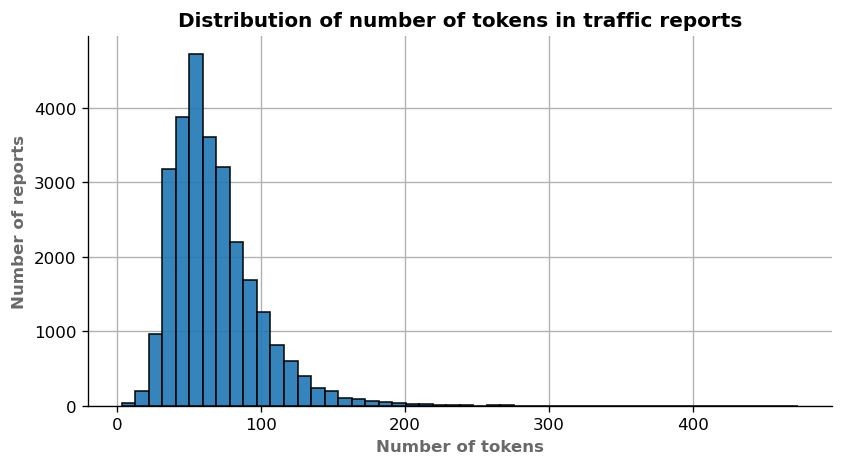

In [7]:
n_tokens = df_reports.content.str.split().str.len()
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
ax.hist(n_tokens, bins=50, edgecolor='black', zorder=10, alpha=0.9)
ax.spines[['right', 'top']].set_visible(False)
ax.set_title('Distribution of number of tokens in traffic reports', fontweight='bold')
ax.set_xlabel('Number of tokens', fontweight='bold', color='dimgray')
ax.set_ylabel('Number of reports', fontweight='bold', color='dimgray')
ax.grid()

## Temporal Analysis

Here, we visualize at which time and on which days most reports are available for.

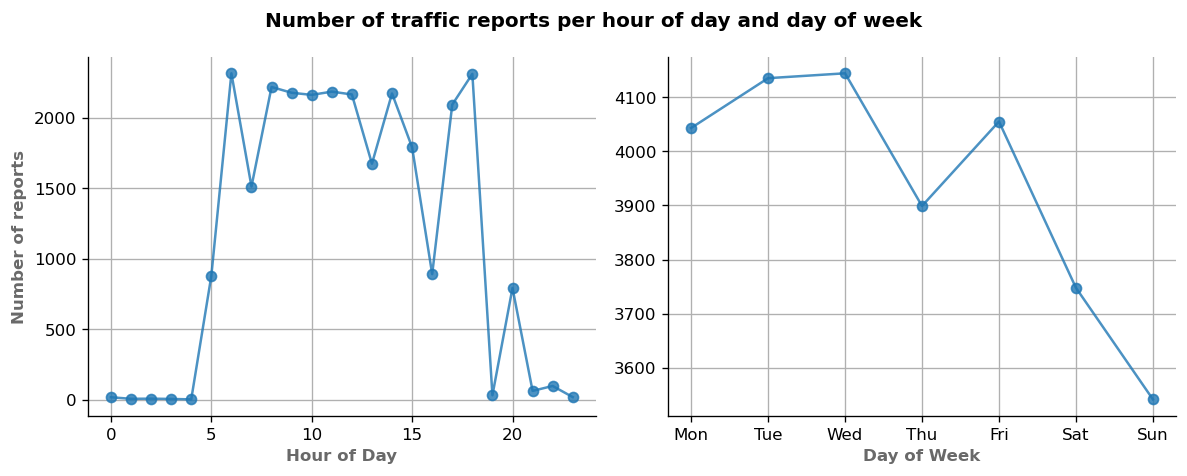

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

counts_per_hour = df_reports.groupby(df_reports.datetime.dt.hour).count()['type']
count_per_weekday = df_reports.groupby(df_reports.datetime.dt.weekday).count()['type']

axs[0].plot(counts_per_hour, '-o', alpha=0.8)
axs[1].plot(count_per_weekday, '-o', alpha=0.8)
axs[0].set_ylabel('Number of reports', fontweight='bold', color='dimgray')
axs[0].set_xlabel('Hour of Day', fontweight='bold', color='dimgray')
axs[1].set_xlabel('Day of Week', fontweight='bold', color='dimgray')
axs[1].set_xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid()
fig.suptitle('Number of traffic reports per hour of day and day of week', fontweight='bold')
fig.tight_layout()